## Tumor Tissue Classification - Histopathologic Cancer
Training a CNN on a dataset of [histopathology patches](https://en.wikipedia.org/wiki/Histopathology). This data corresponds to digitized microscopic analysis of tumor tissue, which has been divided into patches. The objective is to classify the patches into the ones containing tumor tissue, and ones not containing any tumor tissue. We will use the [PCAM dataset](https://github.com/basveeling/pcam) which consists of 96x96 pixel patches. We will only use the validation set (which contains 32768 patches and which should take about 0.8 GB of storage) in order to make the training faster.

In [1]:
import h5py
import random
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.utils import download_file_from_google_drive, _decompress

**Downloading the dataset which is stored in a `.h5` file.**

The images can be download from [here](https://drive.google.com/uc?export=download&id=1hgshYGWK8V-eGRy8LToWJJgDU_rXWVJ3), and the labels from [here](https://drive.google.com/uc?export=download&id=1bH8ZRbhSVAhScTS0p9-ZzGnX91cHT3uO).

In [ ]:
from torchvision.datasets.utils import download_file_from_google_drive, _decompress

# You can run the following cell to download the files on colab
base_folder = "./"
archive_name = "camelyonpatch_level_2_split_valid_x.h5.gz"
download_file_from_google_drive("1hgshYGWK8V-eGRy8LToWJJgDU_rXWVJ3", base_folder, filename=archive_name, md5="d5b63470df7cfa627aeec8b9dc0c066e")
_decompress(base_folder + archive_name)

archive_name = "camelyonpatch_level_2_split_valid_y.h5.gz"
download_file_from_google_drive("1bH8ZRbhSVAhScTS0p9-ZzGnX91cHT3uO", base_folder, filename=archive_name, md5="2b85f58b927af9964a4c15b8f7e8f179")
_decompress(base_folder + archive_name)

I've downloaded the .h5 files in my local

In [2]:

IMAGES_PATH = r'C:\Users\kingr\Downloads\Deep Learning\Assignment\Assignment\camelyonpatch_level_2_split_valid_x.h5'
LABELS_PATH = r'C:\Users\kingr\Downloads\Deep Learning\Assignment\Assignment\camelyonpatch_level_2_split_valid_y.h5'

In [3]:
import warnings

warnings.filterwarnings('ignore')

In [4]:
images = np.array(h5py.File(IMAGES_PATH)['x'])
labels = np.array([y.item() for y in h5py.File(LABELS_PATH)['y']])

Now that we have the data, we will want to split it into a training and a validation set. For this, we will write a function which takes in as input the size of the dataset, and which will return the indices of the training set and the indices of the validation set.

In [5]:
def get_split_indices(dataset_length, train_ratio=0.7):
    """
    Function which splits the data into tranining and validation sets.
    arguments:
        dataset_length [int]: number of elements in the dataset
        train_ratio [float]: ratio of the dataset in the training set
    returns:
        train_indices [list]: list of indices in the training set (of size dataset_length*train_ratio)
        val_indices [list]: list of indices in the validation set (of size dataset_length*(1-train_ratio))
    """
    
    num_train_samples = int(dataset_length * train_ratio)
    
    # Generate a shuffled list of indices from 0 to dataset_length
    indices = list(range(dataset_length))
    random.shuffle(indices)
    
    # Split the indices into training and validation sets
    train_indices = indices[:num_train_samples]
    val_indices = indices[num_train_samples:]
    
    return train_indices, val_indices
  

    

In [6]:
train_indices, val_indices = get_split_indices(len(labels))

*Dataset Creation*

In [7]:
class PCAMDataset(Dataset):
    def __init__(self, data, labels, train):
        """
        Dataset class for the PCAM dataset.
        arguments:
            data [numpy.array]: all RGB 96-96 images
            labels [numpy.array]: corresponding labels
            train [bool]: whether the dataset is training or validation
        """
        super(PCAMDataset, self).__init__()
        self.data = data
        self.labels = labels
        self.train = train

        if self.train:
            
            self.augmentation = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((96, 96)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
            
            #Added Random flip as augmentation.
            
            
        else:
            self.augmentation = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((96, 96)),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
            
            #For val set, no augmentations but resize.
            
            

    def __len__(self):
        
        
        return len(self.data)

        

    def __getitem__(self, idx):
       
        
        image = self.data[idx]
        label = self.labels[idx]
        
        image = self.augmentation(image)
        
        return image, label
        

In [8]:
BATCH_SIZE = 128

In [9]:
train_dataset = PCAMDataset(images[train_indices], labels[train_indices], train=True)
val_dataset = PCAMDataset(images[val_indices], labels[val_indices], train=False)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

*Data Exploring*

In [10]:
import matplotlib.pyplot as plt
import numpy as np

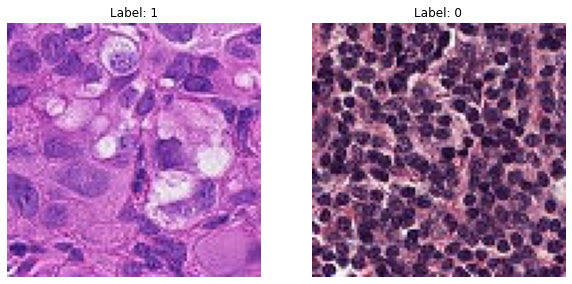

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt



image_tensor_0, label_0 = val_dataset.__getitem__(0)
image_tensor_1, label_1 = val_dataset.__getitem__(2)

image_0 = image_tensor_0.numpy().transpose(1, 2, 0)
image_1 = image_tensor_1.numpy().transpose(1, 2, 0)

mean = 0.5  
std = 0.5   

# Denormalize the images
denorm_image_0 = (image_0 * std) + mean
denorm_image_1 = (image_1 * std) + mean

# Ensure the pixel values are in the correct range for display
denorm_image_0 = np.clip(denorm_image_0, 0, 1)
denorm_image_1 = np.clip(denorm_image_1, 0, 1)


plt.figure(figsize=(10, 5))

# Plot the first image
plt.subplot(1, 2, 1)
plt.imshow(denorm_image_0)
plt.title(f'Label: {label_0}')
plt.axis('off') 

# Plot the second image
plt.subplot(1, 2, 2)
plt.imshow(denorm_image_1)
plt.title(f'Label: {label_1}')
plt.axis('off') 

plt.show()

For *Images with no tumor* - The cells appear uniform and evenly spaced. Cells have consistent shape and size


For *Images with tumor* - We can observe disrupted tissue architecture and presence of irregular shaped clusters can be sign of malignancy

*Class Balance*

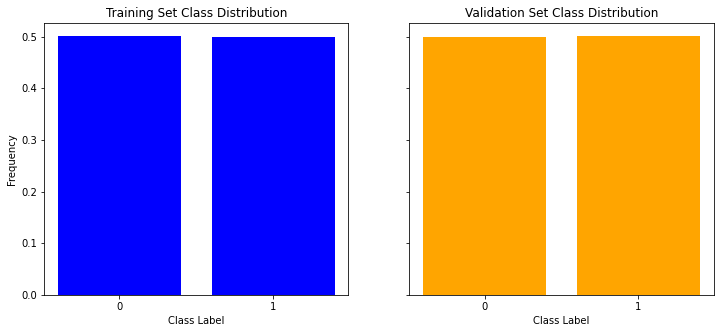

In [12]:
train_labels_list = []
val_labels_list = []

for _, label in train_dataset:
    train_labels_list.append(label)

for _, label in val_dataset:
    val_labels_list.append(label)
    


train_distribution = np.bincount(train_labels_list) / len(train_labels_list)
val_distribution = np.bincount(val_labels_list) / len(val_labels_list)


fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axes[0].bar(['0', '1'], train_distribution, color='blue')
axes[0].set_title('Training Set Class Distribution')
axes[0].set_xlabel('Class Label')
axes[0].set_ylabel('Frequency')

axes[1].bar(['0', '1'], val_distribution, color='orange')
axes[1].set_title('Validation Set Class Distribution')
axes[1].set_xlabel('Class Label')

plt.show()

`Classes are very evenly distributed`

### CNN Model Architecture

- Implemented a bottle neck approach for the architecture design (partly inspired from ResNET). 
- Dynamic convolution layers where number of layers is a hyper parameter to choose. 
- Implemented a custom function to find the shape of output image based on convolution params. 

**Bottle Neck Approach** 

In the first convolution layer, we start with 32 out filters. From here on as we progress through convolution blocks, the image size will be decreased as the number of filters keep increasing. This approach is known to capture the intrinsic features in the input image. 

For example, the number of out filters increase by a power of 2 as number of conv layers increase. 32 -> 64 -> 128 -> 256 e.t.c

In [13]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def findConv2dOutShape(hin, win, conv, pool=2):
    """
    Writing this custom fucntion to calculate the height and width of resultant filters after convolution,
    we need thi to set the number of neurons in input for our fully connected layer

    Args:
        hin : input height
        win : input width
        conv : convolution layer settings
        
    Returns:
        resultant height and width after convolution
    """
    # get conv arguments
    kernel_size = conv.kernel_size
    stride = conv.stride
    padding = conv.padding
    dilation = conv.dilation

    hout = np.floor((hin + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0] + 1)
    wout = np.floor((win + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1] + 1)

    if pool:
        hout /= pool
        wout /= pool
    return int(hout), int(wout)


class FlexConvNet(nn.Module):

    def __init__(self, params):

        super(FlexConvNet, self).__init__()

        Cin, Hin, Win = params['shape_in']
        init_filters = params['initial_filters']
        num_fc1 = params['num_fc1']
        dropout_rate = params['dropout']
        num_conv_layers = params['num_conv_layers']

        # First Convolutional Layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=Cin, out_channels=init_filters, kernel_size=3, padding=0),
            nn.BatchNorm2d(init_filters),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        h, w = findConv2dOutShape(Hin, Win, self.conv1[0], pool=2)

        # Convolutional Blocks
        #Bottle neck approach from here on where we gradually reduce the size of image while increasing the number of filters to capture features.
        #Number of filters increase with a multiple of powers of 2 - like [32, 64, 128, 256, .. etc] - This is a standard approach followed.
         
        self.blocks = nn.ModuleList()
        for i in range(1, num_conv_layers + 1):
            in_channels = init_filters * (2 ** (i - 1))
            out_channels = init_filters * (2 ** i)
            conv_layer = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=1, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, 2)
            )
            self.blocks.append(conv_layer)
            h, w = findConv2dOutShape(h, w, conv_layer[0], pool=2)

        # Dropout layer
        self.dropout2d = nn.Dropout2d()

        # Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Linear(h * w * out_channels, num_fc1),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(num_fc1, 512),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 1)
            # nn.Sigmoid()  
        )

    def forward(self, x):
        x = self.conv1(x)
        for layer in self.blocks:
            x = layer(x)
        #x = self.dropout2d(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)
        return x


In [14]:
params_model = {
    
    'shape_in': (3, 96, 96),
    'initial_filters': 32,
    'num_fc1': 1024,
    'dropout': 0.4,
    'num_conv_layers': 4
        
}

flex_model = FlexConvNet(params_model).to('cuda')

In [15]:
from torchsummary import summary
summary(flex_model, input_size=(3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 94, 94]             896
       BatchNorm2d-2           [-1, 32, 94, 94]              64
              ReLU-3           [-1, 32, 94, 94]               0
         MaxPool2d-4           [-1, 32, 47, 47]               0
            Conv2d-5           [-1, 64, 48, 48]           8,256
       BatchNorm2d-6           [-1, 64, 48, 48]             128
              ReLU-7           [-1, 64, 48, 48]               0
         MaxPool2d-8           [-1, 64, 24, 24]               0
            Conv2d-9          [-1, 128, 25, 25]          32,896
      BatchNorm2d-10          [-1, 128, 25, 25]             256
             ReLU-11          [-1, 128, 25, 25]               0
        MaxPool2d-12          [-1, 128, 12, 12]               0
           Conv2d-13          [-1, 256, 13, 13]         131,328
      BatchNorm2d-14          [-1, 256,

*Training Step*

In [16]:
from torchmetrics.classification import BinaryAccuracy, BinaryAUROC

import torch

In [17]:

lr=0.001
num_epochs = 20
optimizer = torch.optim.Adam(flex_model.parameters(), lr = lr)
criterion = nn.BCEWithLogitsLoss()
metric = BinaryAccuracy().to('cuda')
auroc = BinaryAUROC(thresholds=None).to('cuda')


In [18]:
train_log_flex = []
val_log_flex = []
accuracy_log_flex = []
auc_log_flex = []
val_loss_min_flex = np.Inf
for epoch in range(num_epochs):
    flex_model.train()
    train_loss = 0
    
    for X, y in train_dataloader:
        
        X, y = X.to('cuda') , y.to('cuda').float()
        
        yhat = flex_model(X).squeeze()
        #yhat = flex_model(X)
        loss = criterion(yhat, y)
        
        train_loss += loss.item() * X.size(0)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    avg_train_loss = train_loss / len(train_dataloader.dataset)
    train_log_flex.append(avg_train_loss)
    
    flex_model.eval()
    val_loss = 0
    all_preds = []
    all_y_logits = []
    all_y = []
    with torch.no_grad():
        
        for X, y in val_dataloader:
            
            X,y = X.to('cuda'), y.to('cuda').float()
            
            yhat = flex_model(X).squeeze()
            #yhat = flex_model(X)
            loss_val = criterion(yhat, y)
            
            val_loss += loss_val.item() * X.size(0)
            
            all_y_logits.append(yhat)
            
            preds = torch.sigmoid(yhat)
            
            all_preds.append(preds)
            all_y.append(y)
        
        
        all_preds = torch.cat(all_preds, dim=0)
        all_y = torch.cat(all_y, dim=0)
        all_y_logits = torch.cat(all_y_logits, dim=0)
            
        accuracy = metric(all_preds, all_y)
        auroc_val = auroc(all_y_logits, all_y)
        auc_log_flex.append(auroc_val)
        
        avg_val_loss = val_loss / len(val_dataloader.dataset)
        
        val_log_flex.append(avg_val_loss)
        accuracy_log_flex.append(accuracy)
        
        if avg_val_loss <= val_loss_min_flex:
            
            print('Val loss decreased - Saving current weights')
            torch.save(flex_model.state_dict(), 'best_model_flex.pt')
            val_loss_min_flex = avg_val_loss
        
    print(f"Epoch: {epoch} | Train Loss: {avg_train_loss: .4f} | Val Loss: {avg_val_loss: .4f} | Accuracy = {accuracy: .4f} | AUC score: {auroc_val: .4f}")




Val loss decreased - Saving current weights
Epoch: 0 | Train Loss:  0.4559 | Val Loss:  0.3717 | Accuracy =  0.8482 | AUC score:  0.9233
Val loss decreased - Saving current weights
Epoch: 1 | Train Loss:  0.3085 | Val Loss:  0.2578 | Accuracy =  0.9031 | AUC score:  0.9635
Epoch: 2 | Train Loss:  0.2778 | Val Loss:  0.3153 | Accuracy =  0.8642 | AUC score:  0.9366
Epoch: 3 | Train Loss:  0.2441 | Val Loss:  0.4296 | Accuracy =  0.8124 | AUC score:  0.9403
Epoch: 4 | Train Loss:  0.2105 | Val Loss:  0.2915 | Accuracy =  0.8866 | AUC score:  0.9726
Epoch: 5 | Train Loss:  0.1877 | Val Loss:  0.2919 | Accuracy =  0.8843 | AUC score:  0.9778
Epoch: 6 | Train Loss:  0.1796 | Val Loss:  0.3096 | Accuracy =  0.8835 | AUC score:  0.9758
Val loss decreased - Saving current weights
Epoch: 7 | Train Loss:  0.1678 | Val Loss:  0.2298 | Accuracy =  0.9139 | AUC score:  0.9822
Val loss decreased - Saving current weights
Epoch: 8 | Train Loss:  0.1487 | Val Loss:  0.1682 | Accuracy =  0.9373 | AUC sc

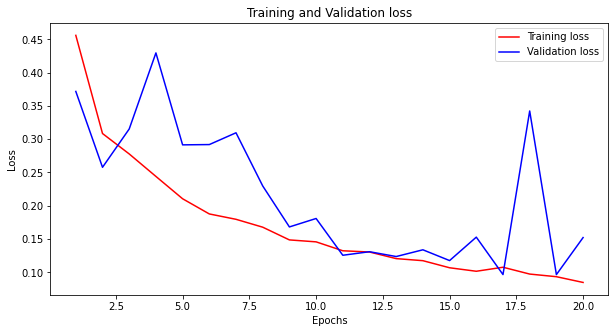

In [19]:
import matplotlib.pyplot as plt


epochs = range(1, len(train_log_flex) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_log_flex, 'r', label='Training loss')
plt.plot(epochs, val_log_flex, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

- From the Above plot we can see that both the validation and train loss decreasing over epochs, but validation loss is not smooth and that is expected. 
- This pattern of increase and decrease of valid loss is expected because of dropouts included as a regularization factor. 
- But nevertheless, I saved the model weights whenever a new lowest validation loss is observed,reaching an accuracy of 96.8% and AUC score of 99.3%

*Metrics Chosen*

- I chose Binary Accuracy and AUC score as the evaluation metrics to observe. (Since our dataset is very well balanced, Just accuracy could've been enough). 
- Since this is a classification task, AUC score makes sense in general as it talks about right classification even when the dataset is not balanced. 

*Loss Critera*

- I chose binary cross entropy with logit loss --> nn.BCEWithLogitLoss() since this is a binary classification problem. I chose this over normal BCELoss because BCEWithLogitLoss() is more stable and it requires logits as input, (and that's the reason I did not add sigmoid activation in the fully connected sequence).



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


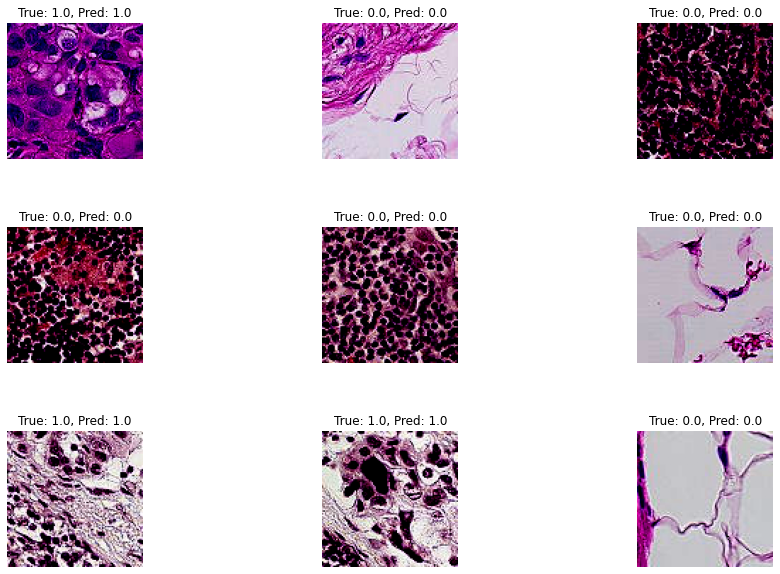

In [22]:
import matplotlib.pyplot as plt
import torch


flex_model.eval()  

images, true_labels, pred_labels = [], [], []

# Collect 9 images and their true labels
with torch.no_grad():
    for X, y in val_dataloader:
        X, y = X.to('cuda'), y.to('cuda').float()
        yhat = torch.sigmoid(flex_model(X).squeeze())  # Get predictions
        preds = (yhat > 0.5 ).float() # Convert predictions to binary labels
        
        images.extend(X.cpu().numpy())  # Move images back to CPU and convert to NumPy for plotting
        true_labels.extend(y.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())
        
        if len(images) >= 9:
            break  # Only need 9 images


fig, axes = plt.subplots(3, 3, figsize=(16, 10))
fig.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].transpose(1, 2, 0))  
    ax.set_title(f"True: {true_labels[i]}, Pred: {pred_labels[i]}")
    ax.axis('off')

plt.show()


**We got an AUC score of 99.45%**